In this notebook we aim to develop a protocole to evaluate OLAF pipelines:


To achieve this task , we will follow this steps:

- Select a corpus.
- Select and create relevent concepts from the corpus.
- Create several pipelines with different components and parameters.
- Run all the pipelines.
- Find concepts involved in complete triples (relation with no null source and destination concepts) for each pipeline.
- Etablish the matching percentage of found concepts compared to selected concepts on step 2.


In [1]:
import spacy
from typing import Set, List
import pandas as pd
from olaf import Pipeline
from olaf.commons.logging_config import logger
from olaf.data_container import CandidateTerm, Relation, Concept
from olaf.data_container.knowledge_representation_schema import KnowledgeRepresentation
from olaf.pipeline.pipeline_component.term_extraction import (
    POSTermExtraction,
    TFIDFTermExtraction,
    ManualCandidateTermExtraction
    )
from olaf.pipeline.pipeline_component.concept_relation_extraction import (
    CTsToConceptExtraction,
    CTsToRelationExtraction,
    SynonymRelationExtraction,
    SynonymConceptExtraction,
    AgglomerativeClusteringRelationExtraction,
    AgglomerativeClusteringConceptExtraction
)
from olaf.commons.spacy_processing_tools import is_not_punct, is_not_stopword, select_on_pos

from olaf.pipeline.pipeline_component.candidate_term_enrichment import SemanticBasedEnrichment

from olaf.repository.corpus_loader.text_corpus_loader import TextCorpusLoader

/home/oumar/Bureau/ontology-learning/env/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matplotlib_venn import venn2, venn3

In [3]:
nlp = spacy.load("en_core_web_lg")

In [4]:
import torch, gc
def free_gpu():
    """
    frees up the GPU cache for other calculations. 
    """
    gc.collect()
    torch.cuda.empty_cache()

free_gpu()

# Select Corpus

In [5]:
corpus_path = "../data/GC10-DET_doc.txt"
corpus_loader = TextCorpusLoader(corpus_path)

# Select and create relevent concepts from the corpus.


In [6]:
expected_concepts = []
with open("../data/concepts.txt", 'r') as f:
    lines = f.readlines()
    expected_concepts = [concept.rstrip("\n") for concept in lines]
    expected_concepts = [Concept(concept) for concept in expected_concepts]
    f.close()

print(expected_concepts)

[Punching, Welding line, Crescent Gap, Water spot, Oil spot, Silk spot, Inclusion, Rolled pit, Crease, Waist folding, metal surface defect, mechanical failure, drying, mechanical lubricant, temperature, pressure, work roll damage, tension roll damage, local yield, low-carbon]


# Testing concept ratio function

In [46]:
from sentence_transformers import SentenceTransformer, util




sentence_transformer_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def hg_lm_similaritiry(embedding_a : str, embedding_b: str, threshold=.8):
    """compute the cosine similarity between two vectors
    """
    return util.pytorch_cos_sim(embedding_a, embedding_b) > threshold

def create_concepts_embedings(concepts: List[Concept], model=sentence_transformer_model) -> List[np.ndarray]:
    """
    Create a embedding list of concepts label from a list of Concepts.
    """
    concept_labels = [concept.label for concept in concepts]
    concept_embedings = model.encode(concept_labels)
    return concept_embedings


def get_unexpected_concepts(concepts: List[Concept], expected_concepts : List[Concept]):
    """
    Return all the concepts obtained that do not appear in those expected.
    """
    unexpected_concepts = []
    concepts = list(concepts)
    concepts_embedings = create_concepts_embedings(concepts)
    expected_concepts_embeding = create_concepts_embedings(expected_concepts)
    for idc, concept_embeding in enumerate(concepts_embedings):
        if not any([hg_lm_similaritiry(concept_embeding, expected_concept_embeding) > 0.7 for expected_concept_embeding in expected_concepts_embeding]):
            unexpected_concepts.append(concepts[idc])
    return unexpected_concepts

def get_concept_ratio(pipeline : Pipeline, expected_concepts : List[Concept], comparator = hg_lm_similaritiry, comparator_args:dict={}, verbose=False) -> tuple:
    """
    Calculate the ratio of expected and unexpected concepts in a given pipeline.

    Parameters
    ----------
    pipeline : Pipeline
        The pipeline object containing concepts.
    expected_concepts : List[Concept]
        A list of expected concepts.kwargs

    Returns
    -------
    Tuple[float, float, float]: A tuple containing:
        precision
        recall
        f-score
    """
    
    
    found_concepts = pipeline.kr.concepts
    if len(found_concepts) <= 0:
        return (0, 0, 0)
    found_concepts_embedings = create_concepts_embedings(found_concepts)
    expected_concepts_embeding = create_concepts_embedings(expected_concepts)
    expected_concept_occ = 0
    for expected_concept in expected_concepts_embeding:
        if verbose:
            print()
            print(f"{expected_concept} : ", end="")
        for found_concept in found_concepts_embedings:
            if comparator(expected_concept, found_concept, **comparator_args):
                expected_concept_occ += 1
                if verbose:
                    print(f"{found_concept} ", end="")
                break 

    recall = expected_concept_occ/len(expected_concepts)
    precision = expected_concept_occ/len(found_concepts)
    f1 = 2*(precision * recall)/(precision+recall)
    return (precision, recall, f1)

In [50]:
from olaf.pipeline.pipeline_component.term_extraction.manual_candidate_terms import (
    ManualCandidateTermExtraction,
)
from olaf.pipeline.pipeline_component.concept_relation_extraction.candidate_terms_to_concepts import CTsToConceptExtraction

from olaf.pipeline.pipeline_component.concept_relation_extraction.candidate_terms_to_relations import CTsToRelationExtraction

# a list of candidate terms by a LLM to create concepts
concepts = [
    "defect type",
    "steel strip surface",
    "punching",
    "mechanical failure",
    "welding line",
    "coil",
    "weld line",
    "crescent gap",
    "cutting",
    "water spot",
    "drying",
    "oil spot",
    "mechanical lubricant",
    "silk spot",
    "plaque",
    "strip surface",
    "roller",
    "pressure",
    "inclusion",
    "metal surface",
    "spots",
    "fish scale shape",
    "block irregular distribution",
    "rolled pit",
    "bulges",
    "pits",
    "steel plate",
    "work roll",
    "tension roll",
    "damage",
    "crease",
    "fold",
    "uncoiling process",
    "waist folding",
    "deformation",
    "low-carbon"
]

# a list of candidate terms by a LLM to create relation
relations = [
    "described",
    "explaining",
    "appears",
    "leads",
    "resulting",
    "changed",
    "produced",
    "drying",
    "caused",
    "affect",
    "appearing",
    "lies",
    "distributed",
    "accompanied",
    "showing",
    "pressed",
    "occurred",
    "circumvented",
    "detected",
    "tracked",
    "results",
    "like",
    "mainly",
    "uncoiling"
]

ct_concept_label = { concept : {concept} for concept in concepts}

manuel_concept_extraction = ManualCandidateTermExtraction(
    ct_label_strings_map=ct_concept_label
)

concept_extraction = CTsToConceptExtraction(
)



relation_extraction = CTsToRelationExtraction()
pipelines = []
pipelines.append(
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
            manuel_concept_extraction,
            concept_extraction,
        ],
        corpus_loader=corpus_loader
    )
)

[2024-06-27 16:52:07,011] [WARNING] [candidate_terms_to_relations] [_check_parameters] [No value given for concept_max_distance parameter, default will be set to 5.]


In [11]:
current_pipeline = pipelines[-1]
get_concept_ratio(current_pipeline, expected_concepts, comparator_args={"threshold":.7}, verbose=True)


Punching : punching 
Welding line : welding line 
Crescent Gap : crescent gap 
Water spot : water spot 
Oil spot : oil spot 
Silk spot : silk spot 
Inclusion : inclusion 
Rolled pit : rolled pit 
Crease : crease 
Waist folding : fold 
metal surface defect : metal surface 
mechanical failure : mechanical failure 
drying : drying 
mechanical lubricant : mechanical lubricant 
temperature : 
pressure : pressure 
work roll damage : work roll 
tension roll damage : tension roll 
local yield : 
low-carbon : low-carbon 

(0.5142857142857142, 0.9, 0.6545454545454545)

In [12]:
get_concept_ratio(current_pipeline, expected_concepts, comparator=is_equal, verbose=True)


Punching : punching 
Welding line : welding line 
Crescent Gap : crescent gap 
Water spot : water spot 
Oil spot : oil spot 
Silk spot : silk spot 
Inclusion : inclusion 
Rolled pit : rolled pit 
Crease : crease 
Waist folding : waist folding 
metal surface defect : 
mechanical failure : mechanical failure 
drying : drying 
mechanical lubricant : mechanical lubricant 
temperature : 
pressure : pressure 
work roll damage : 
tension roll damage : 
local yield : 
low-carbon : low-carbon 

(0.42857142857142855, 0.75, 0.5454545454545454)

In [13]:
debug_get_concept_ratio(current_pipeline, expected_concepts, comparator_args={"threshold":.5})


Punching : punching 
Welding line : welding line 
Crescent Gap : crescent gap 
Water spot : spots 
Oil spot : spots 
Silk spot : spots 
Inclusion : inclusion 
Rolled pit : pits 
Crease : crease 
Waist folding : fold 
metal surface defect : metal surface 
mechanical failure : mechanical failure 
drying : drying 
mechanical lubricant : mechanical lubricant 
temperature : 
pressure : pressure 
work roll damage : work roll 
tension roll damage : tension roll 
local yield : 
low-carbon : low-carbon 

(0.5142857142857142, 0.9, 0.6545454545454545)

## Optimze the similarity threshold


In [14]:
print(get_concept_ratio(current_pipeline, expected_concepts)) # default threshold is 0.8
print(get_concept_ratio(current_pipeline, expected_concepts, comparator_args={"threshold": 0.7}))
print(get_concept_ratio(current_pipeline, expected_concepts, comparator_args={"threshold": 0.6}))
print(get_concept_ratio(current_pipeline, expected_concepts, comparator_args={"threshold": 0.5}))

comparator_args={"threshold": 0.7}

(0.45714285714285713, 0.8, 0.5818181818181818)
(0.5142857142857142, 0.9, 0.6545454545454545)
(0.5142857142857142, 0.9, 0.6545454545454545)
(0.5142857142857142, 0.9, 0.6545454545454545)


# Usefull function

In [24]:
def display_concept(kr : KnowledgeRepresentation) -> None:
    """
    Display the concepts contained in a KnowledgeRepresentation

    Parameters
    ----------
    kr : KnowledgeRepresentation
        The Knowledge Representation containing the concepts and relations.

    Returns
    -------
    None.
    """
    print("Concepts in KR:")
    for concept in kr.concepts:
        print(concept.label)


def display_relation(kr: KnowledgeRepresentation) -> None:
    """
    Display the relations contained in a KnowledgeRepresentation

    Parameters
    ----------
    kr : KnowledgeRepresentation
        The Knowledge Representation containing the concepts and relations.

    Returns
    -------
    None.
    """
    print("Relations in KR:")
    for relation in kr.relations:
        if (
            relation.source_concept is not None
            or relation.destination_concept is not None
        ):
            print(
                (
                    relation.source_concept.label,
                    relation.label,
                    relation.destination_concept.label,
                )
            )

def describe_pipeline(pipeline: Pipeline) -> None:
    """
    Display all pipeline components class names

    Parameters
    ----------
    pipeline : Pipeline
        the pipeline to describe.

    Returns
    -------
    None.
    """
    print(pipeline.__class__.__name__)
    for component in pipeline.pipeline_components:
        print(f"\t {component.__class__.__name__}")

# Creating pipelines

In [23]:
from olaf.pipeline.pipeline_component.term_extraction import (
    ManualCandidateTermExtraction,
    POSTermExtraction,
    TFIDFTermExtraction,
    CvalueTermExtraction
)

from olaf.pipeline.pipeline_component.concept_relation_extraction import (
    CTsToConceptExtraction,
    SynonymConceptExtraction,
    AgglomerativeClusteringConceptExtraction
)


In [22]:
concept_extraction_components = ["CandidatToConcept", "SynonymToConcept", "AgglomerativeClustering"]
term_extraction_components = ["LLM Term Extraction", "POStag Term Extraction", "TFIDF Term Extraction"]
results = pd.DataFrame(
    index=concept_extraction_components,
    columns=term_extraction_components
    )

multi_index = pd.MultiIndex.from_product([
   concept_extraction_components, 
    ["Precision", "Rappel", "F1"]
    ])
pipelines_scores = pd.DataFrame(index=term_extraction_components, columns=multi_index)

pipelines_scores

CandidatToConcept             SynonymToConcept         \
                               Precision Rappel   F1        Precision Rappel   
LLM Term Extraction                  NaN    NaN  NaN              NaN    NaN   
POStag Term Extraction               NaN    NaN  NaN              NaN    NaN   
TFIDF Term Extraction                NaN    NaN  NaN              NaN    NaN   

                            AgglomerativeClustering              
                         F1               Precision Rappel   F1  
LLM Term Extraction     NaN                     NaN    NaN  NaN  
POStag Term Extraction  NaN                     NaN    NaN  NaN  
TFIDF Term Extraction   NaN                     NaN    NaN  NaN

## LLM Term  Extraction

In [21]:
llm_pipelines = []
llm_results = []

### LLM Term  Extraction and Candidat To Concept Extraction

In [ ]:
# concept extraction component
concepts = [
    "defect type",
    "steel strip surface",
    "punching",
    "mechanical failure",
    "welding line",
    "coil",
    "weld line",
    "crescent gap",
    "cutting",
    "water spot",
    "drying",
    "oil spot",
    "mechanical lubricant",
    "silk spot",
    "plaque",
    "strip surface",
    "roller",
    "pressure",
    "inclusion",
    "metal surface",
    "spots",
    "fish scale shape",
    "block irregular distribution",
    "rolled pit",
    "bulges",
    "pits",
    "steel plate",
    "work roll",
    "tension roll",
    "damage",
    "crease",
    "fold",
    "uncoiling process",
    "waist folding",
    "deformation",
    "low-carbon"
]

ct_concept_label = { concept : {concept} for concept in concepts}


llm_pipelines.append(
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
            ManualCandidateTermExtraction(
                ct_label_strings_map=ct_concept_label
            ),
            CTsToConceptExtraction(),
        ],
        corpus_loader=corpus_loader
    )
)
current_pipeline = llm_pipelines[-1]
current_pipeline.run()


llm_results += list( 
    results:=get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)
    )
print(results)

### LLM Term  Extraction and Synonym Concept Extraction

In [25]:

llm_pipelines.append(
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
            ManualCandidateTermExtraction(
                ct_label_strings_map=ct_concept_label
            ),
            SemanticBasedEnrichment(
                threshold=.9
            ),
            SynonymConceptExtraction(),
        ],
            corpus_loader=corpus_loader
    )
)
current_pipeline = llm_pipelines[-1]
current_pipeline.run()

llm_results += list(
    results:=get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)
    )
print(results)

(0.5142857142857142, 0.9, 0.6545454545454545)


### LLM Term  Extraction and Agglomerative Clustering Concept Extraction

In [23]:

llm_pipelines.append(
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
            ManualCandidateTermExtraction(
                ct_label_strings_map=ct_concept_label
            ),
            AgglomerativeClusteringConceptExtraction(
                distance_threshold=.4
            ),
        ],
        corpus_loader=corpus_loader
    )
)
current_pipeline = llm_pipelines[-1]
current_pipeline.run()


llm_results += list(
    results:=get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)
)
print(results)

[2024-06-27 09:15:47,915] [WARNING] [agglomerative_clustering_concept_extraction] [_check_parameters] [No value given for embedding_model parameter, default will be set to all-mpnet-base-v2.]
[2024-06-27 09:15:47,917] [WARNING] [agglomerative_clustering_concept_extraction] [_check_parameters] [No value given for metric option, default will be set to cosine.]


(0.5666666666666667, 0.85, 0.68)


## debugging LLMPipeline

In [46]:
agg_pipeline = llm_pipelines[-1]
debug_get_concept_ratio(agg_pipeline, expected_concepts, comparator_args=comparator_args)


Punching : punching 
Welding line : welding line 
Crescent Gap : crescent gap 
Water spot : water spot 
Oil spot : oil spot 
Silk spot : silk spot 
Inclusion : inclusion 
Rolled pit : rolled pit 
Crease : crease 
Waist folding : fold 
metal surface defect : metal surface 
mechanical failure : mechanical failure 
drying : drying 
mechanical lubricant : mechanical lubricant 
temperature : 
pressure : pressure 
work roll damage : work roll 
tension roll damage : 
local yield : 
low-carbon : low-carbon 

(0.5666666666666667, 0.85, 0.68)

### Score des pipelines

In [24]:
pipelines_scores.loc[term_extraction_components[0]] = llm_results
pipelines_scores

CandidatToConcept                  SynonymToConcept  \
                               Precision Rappel        F1        Precision   
LLM Term Extraction             0.514286    0.9  0.654545         0.514286   
POStag Term Extraction               NaN    NaN       NaN              NaN   
TFIDF Term Extraction                NaN    NaN       NaN              NaN   

                                        AgglomerativeClustering               
                       Rappel        F1               Precision Rappel    F1  
LLM Term Extraction       0.9  0.654545                0.566667   0.85  0.68  
POStag Term Extraction    NaN       NaN                     NaN    NaN   NaN  
TFIDF Term Extraction     NaN       NaN                     NaN    NaN   NaN

### Diagram de venn

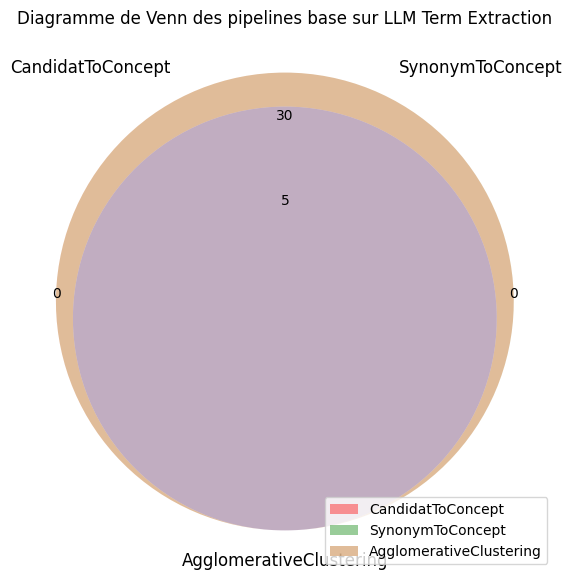

In [25]:
plt.figure(figsize=(19,7))
concepts_sets = [set([concept.label for concept in pipeline.kr.concepts]) for pipeline in llm_pipelines]
venn3(subsets=[concepts_sets[0], concepts_sets[1], concepts_sets[2]], set_labels=tuple(concept_extraction_components))
plt.title("Diagramme de Venn des pipelines base sur LLM Term Extraction")
plt.legend(concept_extraction_components, loc='lower right')


## POS tag Term Extraction

In [26]:
postag_pipelines = []
pos_results = []

### POS tag Term  extraction and Candidat To Concept Extraction

In [27]:
postag_pipelines.append(
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
            POSTermExtraction(
                pos_selection=["NOUN"]
            ),
            CTsToConceptExtraction()
        ],
        corpus_loader=corpus_loader

    )
)
current_pipeline = postag_pipelines[-1]
current_pipeline.run()


pos_results+= list(
    result:=get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)
    )
print(results)

[2024-06-27 09:15:57,867] [WARNING] [pos_term_extraction] [__init__] [No preprocessing function provided for spans. Using the default one.]
[2024-06-27 09:15:57,868] [WARNING] [pos_term_extraction] [_check_parameters] [POS term extraction token sequence attribute not set by the user.
               By default the system will use the entire content of the document.]


(0.5666666666666667, 0.85, 0.68)


In [29]:
debug_get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)


Punching : punching 
Welding line : 
Crescent Gap : gap 
Water spot : 
Oil spot : 
Silk spot : silk 
Inclusion : inclusions 
Rolled pit : pit 
Crease : crease 
Waist folding : folding 
metal surface defect : 
mechanical failure : 
drying : 
mechanical lubricant : lubricant 
temperature : temperature 
pressure : pressure 
work roll damage : 
tension roll damage : 
local yield : yield 
low-carbon : carbon 

(0.0821917808219178, 0.6, 0.14457831325301204)

### POS tag Term  extraction and Synonym Concept Extraction

In [30]:
postag_pipelines.append(
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
            POSTermExtraction(
                pos_selection=["NOUN"]
            ),
            SemanticBasedEnrichment(
                threshold=.9
            ),
            SynonymConceptExtraction()
        ],
            corpus_loader=corpus_loader
    )
)
current_pipeline = postag_pipelines[-1]
current_pipeline.run()


pos_results+= list(
    results:=get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)
    )
print(results)

[2024-06-27 09:16:45,782] [WARNING] [pos_term_extraction] [__init__] [No preprocessing function provided for spans. Using the default one.]
[2024-06-27 09:16:45,783] [WARNING] [pos_term_extraction] [_check_parameters] [POS term extraction token sequence attribute not set by the user.
               By default the system will use the entire content of the document.]


(0.1643835616438356, 0.6, 0.25806451612903225)


### POS tag Term  extraction and Agglomerative clustering Extraction

In [31]:
postag_pipelines.append(
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
            POSTermExtraction(
                pos_selection=["NOUN"]
            ),
            AgglomerativeClusteringConceptExtraction(
                distance_threshold=.3
            )
        ],
        corpus_loader=corpus_loader
    )
)

current_pipeline = postag_pipelines[-1]
current_pipeline.run()

pos_results += list(
        results:=get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)
    )
print(results)

[2024-06-27 09:18:19,945] [WARNING] [pos_term_extraction] [__init__] [No preprocessing function provided for spans. Using the default one.]
[2024-06-27 09:18:19,946] [WARNING] [pos_term_extraction] [_check_parameters] [POS term extraction token sequence attribute not set by the user.
               By default the system will use the entire content of the document.]
[2024-06-27 09:18:19,947] [WARNING] [agglomerative_clustering_concept_extraction] [_check_parameters] [No value given for embedding_model parameter, default will be set to all-mpnet-base-v2.]
[2024-06-27 09:18:19,948] [WARNING] [agglomerative_clustering_concept_extraction] [_check_parameters] [No value given for metric option, default will be set to cosine.]


(0.19047619047619047, 0.6, 0.2891566265060241)


### Score des pipelines

In [32]:
pipelines_scores.loc[term_extraction_components[1]] = pos_results
pipelines_scores

CandidatToConcept                  SynonymToConcept  \
                               Precision Rappel        F1        Precision   
LLM Term Extraction             0.514286    0.9  0.654545         0.514286   
POStag Term Extraction          0.164384    0.6  0.258065         0.164384   
TFIDF Term Extraction                NaN    NaN       NaN              NaN   

                                        AgglomerativeClustering         \
                       Rappel        F1               Precision Rappel   
LLM Term Extraction       0.9  0.654545                0.566667   0.85   
POStag Term Extraction    0.6  0.258065                0.190476    0.6   
TFIDF Term Extraction     NaN       NaN                     NaN    NaN   

                                  
                              F1  
LLM Term Extraction         0.68  
POStag Term Extraction  0.289157  
TFIDF Term Extraction        NaN

### Diagram de venn

/tmp/ipykernel_12572/250563049.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


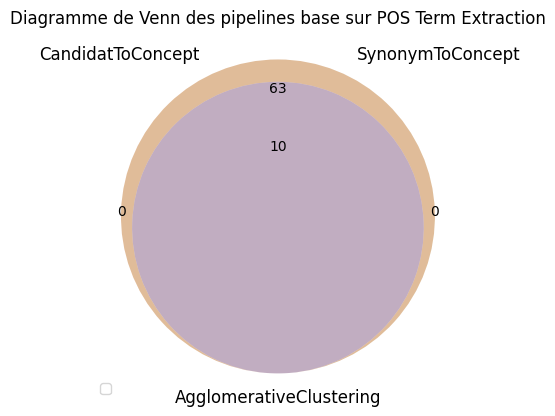

In [33]:
concepts_sets = [set([concept.label for concept in pipeline.kr.concepts]) for pipeline in postag_pipelines]
venn3(subsets=[concepts_sets[0], concepts_sets[1], concepts_sets[2]], set_labels=tuple(concept_extraction_components))
plt.title("Diagramme de Venn des pipelines base sur POS Term Extraction")
plt.legend()


## TFIDF  Term Extraction

In [34]:
tfidf_pipelines = []

tfidf_results = []

In [35]:
## 

def has_not_stopword(terms : Set[CandidateTerm], nlp=nlp,):
    selected_term = []
    for term in terms:
        if is_not_stopword(nlp(term.label)[0]):
            selected_term.append(term)
    return set(selected_term)

def has_not_punct(terms : Set[CandidateTerm], nlp=nlp,):
    selected_term = []
    for term in terms:
        if all([is_not_punct(nlp(char)[0]) for char in term.label]):
            selected_term.append(term)
    return set(selected_term)


bad_pos = ["ADP", "PRON", "CCONJ", "PART", "DET", "INTJ", "SCONJ", "NUM"]

def has_not_bad_pos(terms : Set[CandidateTerm], nlp=nlp, pos_to_avoid: List[str]=bad_pos) -> Set[CandidateTerm]:
    selected_term = []
    for term in terms:
        if not any([doc.pos_ in pos_to_avoid for doc in nlp(term.label)]):
            selected_term.append(term)
    return set(selected_term)

def tidf_postprocessing(terms : Set[CandidateTerm], nlp=nlp) -> Set[CandidateTerm]:

    # has_no_punct = lambda term: any([not is_not_punct(term[i]) for i in range(len(term))])
    terms_doc = [nlp(term.label) for term in terms]
    selected_term = [
        term for term in terms
        if  is_not_punct(nlp(term.label)[0])  
            and is_not_stopword(nlp(term.label)[0])
            and has_not_punct(nlp(term.label)[0])
            and has_not_bad_pos(nlp(term.label)[0])
        ]

    return set(selected_term)

def cts_post_processing(cts: set[CandidateTerm], bad_pos=bad_pos) -> set[CandidateTerm]:
    """Post processing on candidate terms.
    Candidate terms with punctuation, stop words or verbs are removed.

    Parameters
    ----------
    cts: set[CandidateTerm]
        Set of candidate terms to filter.

    Returns
    -------
    set[CandidateTerm]
        The candidate terms validated.    
    """
    existing_cts = []
    new_cts = set()
    for ct in cts:
        keep = True
        if len(ct.corpus_occurrences) > 0:
            for co in ct.corpus_occurrences:
                for token in co:
                    if (not (is_not_punct(token)) or not (is_not_stopword(token)) or (token.pos_ in bad_pos)):
                        keep = False
                        break
        else:
            keep = False
        if keep and ct.label not in existing_cts:
            new_cts.add(ct)
            existing_cts.append(ct.label)
    return new_cts

### TFIDF Term Extraction and Candidat To Concept Extraction

In [36]:
tfidf_pipelines.append(
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
            TFIDFTermExtraction(
                max_term_token_length=3,
                candidate_term_threshold=0.04,
                cts_post_processing_functions=[cts_post_processing]
            ),
            CTsToConceptExtraction()
        ],
        corpus_loader=corpus_loader
    )
)
current_pipeline = tfidf_pipelines[-1]
current_pipeline.run()


# tfidf_results += list(
#     results:=get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)
#     )
# print(results)

[2024-06-27 09:18:38,518] [WARNING] [tfidf_term_extraction] [_check_parameters] [Selected token sequence document attribute not set by the user.
                By default the system will use the entire content of the document.]
/home/oumar/Bureau/ontology-learning/env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [37]:
tfidf_pipelines.append(
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
            TFIDFTermExtraction(
                max_term_token_length=3,
                candidate_term_threshold=.06,
                cts_post_processing_functions=[cts_post_processing]
            ),
            CTsToConceptExtraction()
        ],
        corpus_loader=corpus_loader
    )
)
current_pipeline = tfidf_pipelines[-1]
current_pipeline.run()


tfidf_results += list(
results:=get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)
    )
print(results)

[2024-06-27 09:18:38,660] [WARNING] [tfidf_term_extraction] [_check_parameters] [Selected token sequence document attribute not set by the user.
                By default the system will use the entire content of the document.]


(0.091324200913242, 1.0, 0.16736401673640167)


In [39]:
# debug_get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)

### TFIDF Term Extraction and Synonym Concept Extraction

In [40]:
tfidf_pipelines.append(
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
           TFIDFTermExtraction(
                max_term_token_length=3,
                candidate_term_threshold=.06,
                cts_post_processing_functions=[cts_post_processing]
            ),
            SemanticBasedEnrichment(
                threshold=.9
            ),
            SynonymConceptExtraction()
        ],
        corpus_loader=corpus_loader
    )
)
current_pipeline = tfidf_pipelines[-1]
current_pipeline.run()


tfidf_results += list(
    results:=get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)
    )
print(results)

[2024-06-27 09:19:01,880] [WARNING] [tfidf_term_extraction] [_check_parameters] [Selected token sequence document attribute not set by the user.
                By default the system will use the entire content of the document.]


(0.09174311926605505, 1.0, 0.16806722689075632)


### TFIDF Term Extraction and Agglomerative clustering Concept Extraction

In [41]:
tfidf_pipelines.append(
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
            TFIDFTermExtraction(
                max_term_token_length=3,
                candidate_term_threshold=.05,
                cts_post_processing_functions=[cts_post_processing]
            ),
            AgglomerativeClusteringConceptExtraction(
                distance_threshold=.3
            )
        ],
        corpus_loader=corpus_loader
    )
)
current_pipeline = tfidf_pipelines[-1]
current_pipeline.run()


tfidf_results += list(
    get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)
)

[2024-06-27 09:21:58,185] [WARNING] [tfidf_term_extraction] [_check_parameters] [Selected token sequence document attribute not set by the user.
                By default the system will use the entire content of the document.]
[2024-06-27 09:21:58,186] [WARNING] [agglomerative_clustering_concept_extraction] [_check_parameters] [No value given for embedding_model parameter, default will be set to all-mpnet-base-v2.]
[2024-06-27 09:21:58,187] [WARNING] [agglomerative_clustering_concept_extraction] [_check_parameters] [No value given for metric option, default will be set to cosine.]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 1.96 GiB of which 4.56 MiB is free. Including non-PyTorch memory, this process has 1.45 GiB memory in use. Of the allocated memory 1.31 GiB is allocated by PyTorch, and 113.70 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Scores des pipelines

In [ ]:
pipelines_scores

CandidatToConcept                  SynonymToConcept  \
                               Precision Rappel        F1        Precision   
LLM Term Extraction             0.514286    0.9  0.654545         0.514286   
POStag Term Extraction          0.164384    0.6  0.258065         0.164384   
TFIDF Term Extraction              0.121    0.9     0.213            0.121   

                                        AgglomerativeClustering         \
                       Rappel        F1               Precision Rappel   
LLM Term Extraction       0.9  0.654545                0.566667   0.85   
POStag Term Extraction    0.6  0.258065                0.190476    0.6   
TFIDF Term Extraction     0.9     0.213                   0.125    1.0   

                                  
                              F1  
LLM Term Extraction         0.68  
POStag Term Extraction  0.289157  
TFIDF Term Extraction      0.222

### Diagram de venn

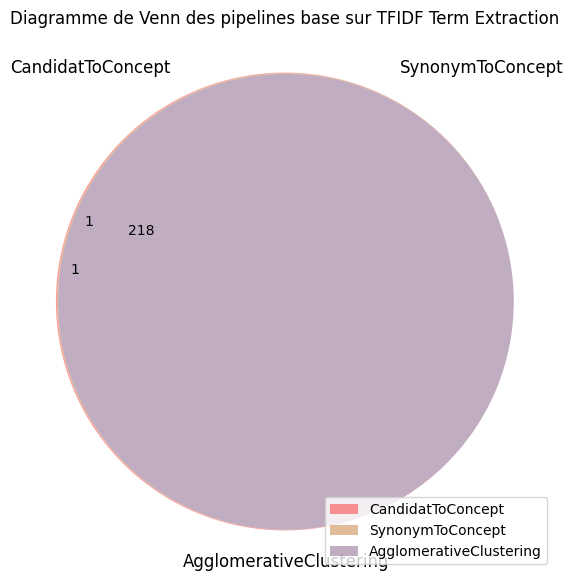

In [ ]:
plt.figure(figsize=(19,7))
concepts_sets = [set([concept.label for concept in pipeline.kr.concepts]) for pipeline in tfidf_pipelines]
venn3(subsets=[concepts_sets[0], concepts_sets[1], concepts_sets[2]], set_labels=tuple(concept_extraction_components))
plt.title("Diagramme de Venn des pipelines base sur TFIDF Term Extraction")
plt.legend(concept_extraction_components, loc='lower right')


# Visualisation des Resultats

## Diagramme de Venn des extracteur de terms

In [ ]:
term_extraction_only_pipeline = [
     Pipeline(
        spacy_model=nlp,
        pipeline_components=[
            ManualCandidateTermExtraction(
                ct_label_strings_map=ct_concept_label
            )
        ],
        corpus_loader=corpus_loader
    ),
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
            POSTermExtraction(
                pos_selection=["NOUN"]
            )
            ],
        corpus_loader=corpus_loader
    ),
     Pipeline(
        spacy_model=nlp,
        pipeline_components=[
           TFIDFTermExtraction(
                max_term_token_length=3,
                candidate_term_threshold=.03,
                cts_post_processing_functions=[cts_post_processing]
            )
        ],
        corpus_loader=corpus_loader
    ),
]

candidate_terms = [pipeline.candidate_terms for pipeline in term_extraction_only_pipeline]

candidate_terms = [set([term.label.lower() for term in term_set]) for term_set in candidate_terms]

venn3(subsets=[candidate_terms[0], candidate_terms[1], candidate_terms[2]], set_labels=tuple(term_extraction_components))
plt.title("Diagramme de Venn des pipelines base sur TFIDF Term Extraction")
plt.legend(concept_extraction_components, loc='lower right')

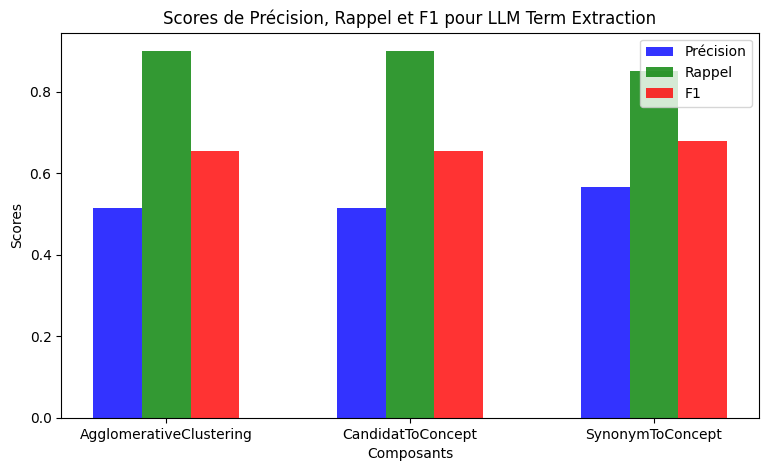

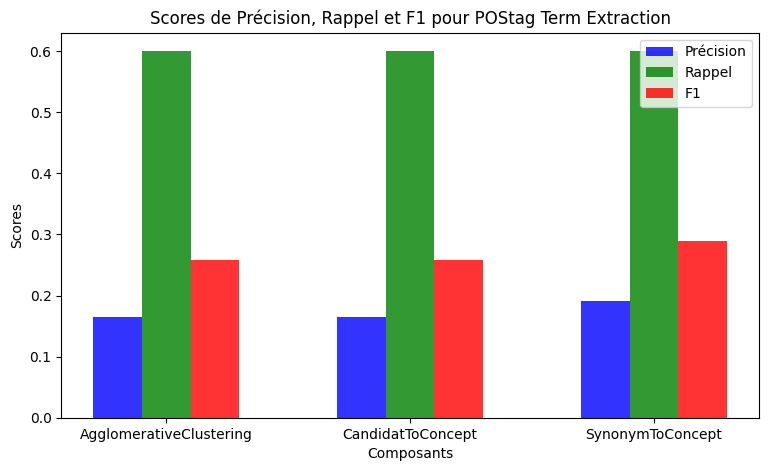

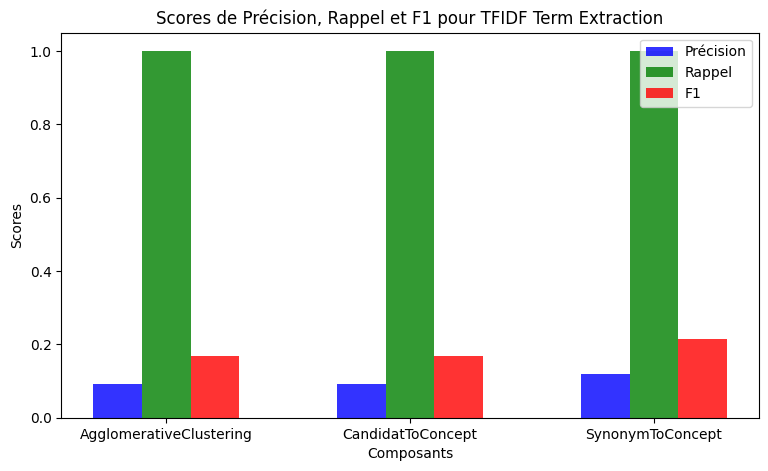

In [ ]:
# Fonction pour créer les diagrammes en barres
def create_bar_chart(index_name, data):
    fig, ax = plt.subplots(figsize=(9, 5))
    bar_width = 0.2
    opacity = 0.8

    # Configurer les positions des barres
    r1 = np.arange(len(data.columns.levels[0]))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    precision = data.loc[index_name].xs('Precision', level=1)
    rappel = data.loc[index_name].xs('Rappel', level=1)
    f1 = data.loc[index_name].xs('F1', level=1)

    rects1 = ax.bar(r1, precision, bar_width, alpha=opacity, color='b', label='Précision')
    rects2 = ax.bar(r2, rappel, bar_width, alpha=opacity, color='g', label='Rappel')
    rects3 = ax.bar(r3, f1, bar_width, alpha=opacity, color='r', label='F1')

    ax.set_xlabel('Composants')
    ax.set_ylabel('Scores')
    ax.set_title(f'Scores de Précision, Rappel et F1 pour {index_name}')
    ax.set_xticks([r + bar_width for r in range(len(data.columns.levels[0]))])
    ax.set_xticklabels(data.columns.levels[0])
    ax.legend()

    plt.show()

# Créer un diagramme en barres pour chaque index
for idx in term_extraction_components:
    create_bar_chart(idx, pipelines_scores)

In [ ]:
def create_bar_chart(index_name, data):
    precision = data.loc[index_name].xs('Precision', level=1)
    rappel = data.loc[index_name].xs('Rappel', level=1)
    f1 = data.loc[index_name].xs('F1', level=1)

    fig = go.Figure(data=[
        go.Bar(name='Précision', x=data.columns.levels[0], y=precision),
        go.Bar(name='Rappel', x=data.columns.levels[0], y=rappel),
        go.Bar(name='F1', x=data.columns.levels[0], y=f1)
    ])
    
    # Modifier la disposition du graphique
    fig.update_layout(
        title=f'Scores de Précision, Rappel et F1 pour {index_name}',
        xaxis_title='Composants',
        yaxis_title='Scores',
        barmode='group'
    )
    
    fig.show()


def create_bar_chart(index_name, data):
    df = data[data['Extraction'] == index_name]
    fig = px.bar(df, x='Composant', y='Score', color='Métrique', barmode='group',
                 title=f'Scores de Précision, Rappel et F1 pour {index_name}')
    
    fig.update_layout(
        xaxis_title='Composants',
        yaxis_title='Scores'
    )
    fig.update_layout(width=1000, height=600)
    fig.show()

data_long = pipelines_scores.reset_index().melt(id_vars='index', var_name=['Composant', 'Métrique'], value_name='Score')
data_long.rename(columns={'index': 'Extraction'}, inplace=True)

# Créer un diagramme en barres pour chaque index
for idx in term_extraction_components:
    create_bar_chart(idx, data_long)

# Conclusion

In [ ]:
new_data = pd.DataFrame(index=term_extraction_components, columns=['Précision', 'Rappel', 'F1', 'Composant'])

# Trouver le composant avec la F1 la plus élevée pour chaque index
for idx in term_extraction_components:
    f1_values = pipelines_scores.loc[idx].xs('F1', level=1)
    max_f1_component = f1_values.idxmax()
    new_data.loc[idx, 'Précision'] = pipelines_scores.loc[idx, (max_f1_component, 'Precision')]
    new_data.loc[idx, 'Rappel'] = pipelines_scores.loc[idx, (max_f1_component, 'Rappel')]
    new_data.loc[idx, 'F1'] = pipelines_scores.loc[idx, (max_f1_component, 'F1')]
    new_data.loc[idx, 'Composant'] = max_f1_component

new_data.index = new_data.index + " / " + new_data['Composant']

# Supprimer la colonne 'Composant'
new_data.drop(columns=['Composant'], inplace=True)


# Afficher le nouveau DataFrame
print("\nNouveau DataFrame avec le composant ayant la plus grande F1:")
print(new_data)


Nouveau DataFrame avec le composant ayant la plus grande F1:
                                                 Précision Rappel        F1
LLM Term Extraction / AgglomerativeClustering     0.566667   0.85      0.68
POStag Term Extraction / AgglomerativeClustering  0.190476    0.6  0.289157
TFIDF Term Extraction / AgglomerativeClustering    0.11976    1.0  0.213904


In [ ]:
data_long = new_data.reset_index().melt(id_vars='index', var_name='Métrique', value_name='Score')
data_long.rename(columns={'index': 'Extraction - Composant'}, inplace=True)

# Créer le diagramme en barres groupées avec plotly.express
fig = px.bar(data_long, x='Extraction - Composant', y='Score', color='Métrique', barmode='group',
             title='Scores de Précision, Rappel et F1 pour chaque Extraction - Composant')

fig.update_layout(
    xaxis_title='Extraction - Composant',
    yaxis_title='Score'
)

fig.show()

